    comparativa datasets notebook
    

In [1]:
import os
import re
import warnings
import pandas as pd
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# =========================
# 1) Carpeta con los datos
# =========================
base_path = Path.cwd().parent / "data/data_comparativa"

# =========================
# 2) Listado de CSVs (.csv y .csv.gz)
# =========================
csv_files = []
for pattern in ("*.csv", "*.csv.gz"):
    csv_files.extend(base_path.glob(pattern))
if not csv_files:
    raise FileNotFoundError(f"No se encontraron archivos CSV en {base_path}")

# =========================
# Helper: extraer fecha del nombre del archivo
# - Priorizamos una fecha al FINAL del nombre (antes de la extensión), p. ej.:
#     consulta_03_30dias_2025-08-21.csv   -> 2025-08-21
#     consulta_02_2025-08-27.csv          -> 2025-08-27
# - Si hay varias fechas en el nombre, usamos la ÚLTIMA coincidencia.
# - Devuelve una tupla (granularidad, clave, datetime) donde:
#     granularidad ∈ {"day","month","year"}
#     clave        ∈ {"YYYY-MM-DD", "YYYY-MM", "YYYY"}
# =========================
def extract_date_from_name(name: str):
    stem = Path(name).stem.lower()

    # Listas de patrones (DAY primero, luego MONTH, luego YEAR)
    # Buscamos TODAS y nos quedamos con la ÚLTIMA
    patterns_day = [
        r"(20\d{2})[-_]?([01]\d)[-_]?([0-3]\d)$",           # YYYY-MM-DD / YYYY_MM_DD / YYYYMMDD al final
        r"(20\d{2})[-_]?([01]\d)[-_]?([0-3]\d)\b",          # en cualquier parte
        r"([0-3]\d)[-_]([01]\d)[-_](20\d{2})$",
        r"([0-3]\d)[-_]([01]\d)[-_](20\d{2})\b",
    ]
    patterns_month = [
        r"(20\d{2})[-_]?([01]\d)$",                         # YYYY-MM / YYYYMM al final
        r"(20\d{2})[-_]?([01]\d)\b",
    ]
    patterns_year = [
        r"(20\d{2})$",
        r"(20\d{2})\b",
    ]

    def find_last(patterns, builder):
        last = None
        for pat in patterns:
            for m in re.finditer(pat, stem):
                try:
                    dt, key = builder(m)
                    last = (dt, key)
                except ValueError:
                    continue
        return last

    # Builders
    def build_day(m):
        # Puede venir como YYYY MM DD o DD MM YYYY según patrón
        g = m.groups()
        if len(g) == 3:
            # Probamos dos órdenes
            try:
                y, mo, d = int(g[0]), int(g[1]), int(g[2])
            except ValueError:
                y, mo, d = None, None, None
            if y and 2000 <= y <= 2099:
                dt = datetime(y, mo, d)
                return dt, dt.strftime("%Y-%m-%d")
            # Alternativa: DD-MM-YYYY
            d, mo, y = int(g[0]), int(g[1]), int(g[2])
            dt = datetime(y, mo, d)
            return dt, dt.strftime("%Y-%m-%d")
        raise ValueError

    def build_month(m):
        y, mo = int(m.group(1)), int(m.group(2))
        dt = datetime(y, mo, 1)
        return dt, dt.strftime("%Y-%m")

    def build_year(m):
        y = int(m.group(1))
        dt = datetime(y, 1, 1)
        return dt, str(y)

    # Prioridad: día > mes > año (cada uno toma la última coincidencia)
    last_day = find_last(patterns_day, build_day)
    if last_day:
        dt, key = last_day
        return ("day", key, dt)

    last_month = find_last(patterns_month, build_month)
    if last_month:
        dt, key = last_month
        return ("month", key, dt)

    last_year = find_last(patterns_year, build_year)
    if last_year:
        dt, key = last_year
        return ("year", key, dt)

    return None

# =========================
# 3) Cargar TODOS los CSV agrupados por fecha EN NOMBRE
#    (Ignoramos archivos sin fecha detectable en el nombre)
# =========================
dfs_por_fecha_tmp = defaultdict(list)
archivos_sin_fecha = []

for fp in csv_files:
    info = extract_date_from_name(fp.name)
    if info is None:
        archivos_sin_fecha.append(fp.name)
        continue
    gran, date_key, _ = info
    df = pd.read_csv(fp, low_memory=False)
    dfs_por_fecha_tmp[date_key].append(df)

if archivos_sin_fecha:
    warnings.warn(
        "Se ignoraron archivos sin fecha en el nombre (no se usa mtime):\n  - " +
        "\n  - ".join(archivos_sin_fecha)
    )

# =========================
# 4) Concatenar si hay varios archivos para la misma fecha
# =========================
dfs_por_fecha = {}
for date_key, parts in dfs_por_fecha_tmp.items():
    if len(parts) == 1:
        dfs_por_fecha[date_key] = parts[0]
    else:
        dfs_por_fecha[date_key] = pd.concat(parts, ignore_index=True)

# =========================
# 5) Mostrar resumen
# =========================
print("✅ Fechas detectadas en nombre y tamaños:")
for k in sorted(dfs_por_fecha):
    print(f"  - {k}: {dfs_por_fecha[k].shape[0]:,} filas x {dfs_por_fecha[k].shape[1]} cols")

# =========================
# 6) Elegir extremos por FECHA EN NOMBRE (no mtime)
#    Admitimos claves 'YYYY', 'YYYY-MM', 'YYYY-MM-DD'
# =========================
def parse_key_to_datetime(key: str) -> datetime:
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", key):
        return datetime.strptime(key, "%Y-%m-%d")
    if re.fullmatch(r"\d{4}-\d{2}", key):
        return datetime.strptime(key, "%Y-%m")
    if re.fullmatch(r"\d{4}", key):
        return datetime.strptime(key, "%Y")
    raise ValueError(f"Formato de clave de fecha no soportado: {key}")

if not dfs_por_fecha:
    raise RuntimeError("No hay archivos válidos con fecha en el nombre.")

fechas_ordenadas = sorted(dfs_por_fecha.keys(), key=parse_key_to_datetime)
fecha_oldest = fechas_ordenadas[0]
fecha_latest = fechas_ordenadas[-1]

def varname_for_key(key: str) -> str:
    return f"df_{key.replace('-', '_')}"

globals()[varname_for_key(fecha_oldest)] = dfs_por_fecha[fecha_oldest]
globals()[varname_for_key(fecha_latest)] = dfs_por_fecha[fecha_latest]

print(f"\n📂 Más antiguo (por nombre): {fecha_oldest} -> variable creada: {varname_for_key(fecha_oldest)} "
      f"({dfs_por_fecha[fecha_oldest].shape[0]:,} x {dfs_por_fecha[fecha_oldest].shape[1]})")
print(f"📂 Más reciente (por nombre): {fecha_latest} -> variable creada: {varname_for_key(fecha_latest)} "
      f"({dfs_por_fecha[fecha_latest].shape[0]:,} x {dfs_por_fecha[fecha_latest].shape[1]})")

# =========================
# 7) Cargar Excel validado como DFDatosValidados (y normalizar ranch_name)
# =========================
excel_file = base_path / "datos_validados.xlsx"

def asegurar_col_ranch(df, preferidas=("ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería")):
    for c in preferidas:
        if c in df.columns:
            return c
    return None

if excel_file.exists():
    DFDatosValidados = pd.read_excel(excel_file)
    col_ranch = asegurar_col_ranch(DFDatosValidados)
    if col_ranch is None:
        raise KeyError("No encuentro columna de ganadería en DFDatosValidados (busqué ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    if col_ranch != "ranch_name":
        DFDatosValidados = DFDatosValidados.rename(columns={col_ranch: "ranch_name"})
    print(f"✅ DFDatosValidados cargado: {DFDatosValidados.shape[0]:,} filas x {DFDatosValidados.shape[1]} cols")
else:
    raise FileNotFoundError(f"No se encontró {excel_file}. Crea/coloca el Excel para cargar DFDatosValidados.")

# --- USO ---
# - Accede a cualquier fecha concreta con dfs_por_fecha["YYYY-MM-DD"] (o "YYYY-MM", "YYYY").
# - Variables creadas automáticamente para extremos por nombre:
#     -> df_YYYY_MM_DD / df_YYYY_MM / df_YYYY
# - Archivos sin fecha en el nombre se ignoran (listados en un warning).


✅ Fechas detectadas en nombre y tamaños:
  - 2025-08-21: 9,132 filas x 42 cols
  - 2025-08-27: 9,127 filas x 42 cols

📂 Más antiguo (por nombre): 2025-08-21 -> variable creada: df_2025_08_21 (9,132 x 42)
📂 Más reciente (por nombre): 2025-08-27 -> variable creada: df_2025_08_27 (9,127 x 42)
✅ DFDatosValidados cargado: 16 filas x 11 cols


DISPOSITIVOS SOLO PLACAS PRO AGRUPADA POR GANADERIA


In [7]:
import pandas as pd
import numpy as np
import re

# ========= util: división segura (evita /0) =========
def pct(num, den):
    num = pd.to_numeric(num, errors="coerce")
    den = pd.to_numeric(den, errors="coerce")
    return np.where(den > 0, (num / den) * 100.0, np.nan)

def asegurar_col(df, candidatos):
    """Devuelve el nombre EXACTO de la primera columna presente en df de entre 'candidatos' (respetando mayúsculas y comillas)."""
    for c in candidatos:
        if c in df.columns:
            return c
    # intento extra: case-insensitive y tolerando comillas
    low = {str(c).lower(): c for c in df.columns}
    for c in candidatos:
        key = str(c).strip('"').lower()
        if key in low:
            return low[key]
        if f'"{key}"' in low:
            return low[f'"{key}"']
    return None

def rename_first_match(df, target_name, candidates):
    """
    Busca la primera columna presente entre 'candidatos' y la renombra a 'target_name'.
    Devuelve (df_mod, found_name) o (df, None) si no encontró.
    """
    col = asegurar_col(df, candidates)
    if col is None:
        return df, None
    if col != target_name:
        df = df.rename(columns={col: target_name})
    return df, col

def normaliza_ranch(df):
    df, found = rename_first_match(df, "ranch_name",
                                   ["ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería"])
    if found is None:
        raise KeyError("No encuentro columna de ganadería (ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    return df

def normaliza_device(df):
    df, found = rename_first_match(df, "device_id", ["device_id","DeviceId","dispositivo","id_device","device"])
    if found is None:
        # si no hay device_id, crea nulo (pero avisamos)
        print("⚠️  No hay 'device_id' en el DataFrame; se creará vacío (podría dar n_dispositivos=0).")
        df = df.copy()
        df["device_id"] = np.nan
    return df

def normaliza_modelo(df):
    """
    Busca columna de modelo y la estandariza a 'modelo'.
    Es obligatoria para poder filtrar (cow_pro / ixo_track_pro).
    """
    df, found = rename_first_match(df, "modelo", ["modelo", "Modelo", "model", "device_model", "DeviceModel", "DeviceType", "device_type"])
    if found is None:
        raise KeyError("No encuentro columna de modelo (modelo/Modelo/model/device_model/DeviceModel/DeviceType/device_type).")
    return df

def diagnostico_columnas_detectadas(mapeo_detectado):
    if not mapeo_detectado:
        return
    print("🔎 Columnas detectadas y mapeadas:")
    for estandar, alias in mapeo_detectado.items():
        print(f"   - {estandar}  <=  {alias}")

# ========= construcción por GANADERÍA (robusta a alias y sin sobreconteo) =========
def construir_df_ganaderias_desde_raw(df: pd.DataFrame,
                                      modelos_permitidos=("cow_pro", "ixo_track_pro")) -> pd.DataFrame:
    """
    Toma el DF detallado (varias filas por device_id posibles) y devuelve
    la tabla agregada por ganadería con métricas y %,
    normalizando alias y evitando sobreconteo.
    Solo incluye filas cuyo modelo esté en 'modelos_permitidos'.
    """
    if df is None or df.empty:
        return pd.DataFrame()

    df = df.copy()

    # --- Normalizaciones básicas ---
    df = normaliza_ranch(df)
    df = normaliza_device(df)
    df = normaliza_modelo(df)

    # --- 🔎 FILTRADO de modelos permitidos ---
    modelos_set = {str(m).strip().lower() for m in modelos_permitidos}
    df["modelo"] = df["modelo"].astype(str).str.strip().str.lower()
    df = df[df["modelo"].isin(modelos_set)].copy()
    if df.empty:
        print("⚠️  No hay registros con modelos cow_pro o ixo_track_pro en este dataset tras normalizar.")
        return pd.DataFrame()

    # --- Mapeo de alias a nombres ESTÁNDAR (los de consulta 2) ---
    alias_map = {
        # esperados por día
        "Mensajes esperados (detallado)": [
            'Mensajes esperados (detallado)', '"Mensajes esperados (detallado)"',
            'mensajes_esperados', 'mensajes_esperados_por_dia', 'mensajes_esperados_por_día',
            'UplinksPerDay', 'mensajes_esperados_detallado'
        ],
        # recibidos
        "Mensajes recibidos (n)": [
            'Mensajes recibidos (n)', '"Mensajes recibidos (n)"',
            'mensajes_recibidos', 'Promedio mensajes recibidos/día', 'recibidos_n'
        ],
        # con GPS
        "Mensaje con posición GPS (n)": [
            'Mensaje con posición GPS (n)', '"Mensaje con posición GPS (n)"',
            'mensajes_con_gps', 'Promedio mensajes con GPS/día', 'con_gps_n'
        ],
        # válidas
        "Posición GPS válida (n)": [
            'Posición GPS válida (n)', '"Posición GPS válida (n)"',
            'posiciones_validas', 'Promedio posiciones válidas/día', 'validas_n'
        ],
        # baja precisión
        "Baja precisión (n)": [
            'Baja precisión (n)', '"Baja precisión (n)"',
            'baja_precision', 'Promedio baja precisión/día', 'baja_precision_n'
        ],
        # no válidas
        "Posición GPS no válida (n)": [
            'Posición GPS no válida (n)', '"Posición GPS no válida (n)"',
            'posiciones_no_validas', 'Promedio no válidas/día', 'no_validas_n'
        ],
        # no válida calidad gps
        "No válida por calidad GPS (n)": [
            'No válida por calidad GPS (n)', '"No válida por calidad GPS (n)"',
            'no_valida_calidad', 'Promedio no válida por calidad GPS/día', 'no_valida_calidad_gps_n'
        ],
        # no válida velocidad
        "No válida por filtro velocidad (n)": [
            'No válida por filtro velocidad (n)', '"No válida por filtro velocidad (n)"',
            'no_valida_velocidad', 'Promedio no válida por velocidad/día', 'no_valida_filtro_velocidad_n'
        ],
    }

    mapeo_detectado = {}
    for estandar, candidatos in alias_map.items():
        df, found = rename_first_match(df, estandar, candidatos)
        if found is not None:
            mapeo_detectado[estandar] = found

    # Diagnóstico útil en consola
    diagnostico_columnas_detectadas(mapeo_detectado)

    # Comprobación estricta de columnas mínimas
    base_necesarias = [
        "Mensajes esperados (detallado)",
        "Mensajes recibidos (n)",
        "Mensaje con posición GPS (n)",
        "Posición GPS válida (n)",
        "Baja precisión (n)",
        "Posición GPS no válida (n)",
        "No válida por calidad GPS (n)",
        "No válida por filtro velocidad (n)",
    ]
    faltantes = [c for c in base_necesarias if c not in df.columns]
    if faltantes:
        raise KeyError(
            "Faltan columnas necesarias en el DataFrame de entrada.\n"
            f"Faltan: {faltantes}\n"
            "Revisa que el CSV tenga los encabezados esperados o añade sus alias al 'alias_map'."
        )

    # Asegurar numérico (si venían como string)
    for c in base_necesarias:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # ---------- (1) CONSOLIDAR por (ranch_name, device_id) ----------
    by_dev = (
        df.groupby(["ranch_name","device_id"], dropna=False)[base_necesarias]
          .sum(min_count=1)
          .reset_index()
    )

    # ---------- (2) Recalcular OK por DISPOSITIVO con consolidados ----------
    ok_col = "Dispositivo OK (≥60% válidas vs esperadas)"
    den = by_dev["Mensajes esperados (detallado)"].astype(float)
    num = by_dev["Posición GPS válida (n)"].astype(float)
    pct_valid_vs_expected = np.where(den > 0, (num / den) * 100.0, np.nan)
    by_dev[ok_col] = np.where(~np.isnan(pct_valid_vs_expected), pct_valid_vs_expected >= 60.0, False)
    by_dev[ok_col] = by_dev[ok_col].fillna(False).astype(bool)

    # ---------- (3) AGREGADO final por GANADERÍA ----------
    agr_cols = {
        "device_id": "nunique",
        "Mensajes esperados (detallado)": "sum",
        "Mensajes recibidos (n)": "sum",
        "Mensaje con posición GPS (n)": "sum",
        "Posición GPS válida (n)": "sum",
        "Baja precisión (n)": "sum",
        "Posición GPS no válida (n)": "sum",
        "No válida por calidad GPS (n)": "sum",
        "No válida por filtro velocidad (n)": "sum",
        ok_col: "sum",
    }

    agg = (
        by_dev.groupby("ranch_name", dropna=False)
              .agg(agr_cols)
              .rename(columns={
                  "device_id": "n_dispositivos",
                  ok_col: "dispositivos_ok",
              })
              .reset_index()
    )

    # ---------- (4) Porcentajes de calidad a nivel GANADERÍA ----------
    def add_pct(target_df, num_col, den_col, out_col):
        if num_col in target_df.columns and den_col in target_df.columns:
            target_df[out_col] = pct(target_df[num_col], target_df[den_col])
        return target_df

    agg = add_pct(agg, "Mensajes recibidos (n)",           "Mensajes esperados (detallado)", "Mensajes recibidos (%)")
    agg = add_pct(agg, "Mensaje con posición GPS (n)",     "Mensajes recibidos (n)",         "Mensaje con posición GPS (%)")
    agg = add_pct(agg, "Posición GPS válida (n)",          "Mensajes recibidos (n)",         "Posición GPS válida (%)")
    agg = add_pct(agg, "Baja precisión (n)",               "Posición GPS válida (n)",        "Baja precisión (%)")
    agg = add_pct(agg, "Posición GPS no válida (n)",       "Mensajes recibidos (n)",         "Posición GPS no válida (%)")
    agg = add_pct(agg, "No válida por calidad GPS (n)",    "Posición GPS no válida (n)",     "No válida por calidad GPS (%)")
    agg = add_pct(agg, "No válida por filtro velocidad (n)","Posición GPS no válida (n)",    "No válida por filtro velocidad (%)")

    # % de dispositivos OK y flag global
    agg["% dispositivos OK en ganadería"] = pct(agg["dispositivos_ok"].astype(float),
                                                agg["n_dispositivos"].astype(float))
    agg["Ganadería OK (≥70% dispositivos OK)"] = (agg["% dispositivos OK en ganadería"] >= 70.0)

    # ---------- (5) Orden de columnas ----------
    cols = [
        "ranch_name", "n_dispositivos", "dispositivos_ok", "% dispositivos OK en ganadería",
        "Ganadería OK (≥70% dispositivos OK)",
        "Mensajes esperados (detallado)", "Mensajes recibidos (n)", "Mensajes recibidos (%)",
        "Mensaje con posición GPS (n)", "Mensaje con posición GPS (%)",
        "Posición GPS válida (n)", "Posición GPS válida (%)",
        "Baja precisión (n)", "Baja precisión (%)",
        "Posición GPS no válida (n)", "Posición GPS no válida (%)",
        "No válida por calidad GPS (n)", "No válida por calidad GPS (%)",
        "No válida por filtro velocidad (n)", "No válida por filtro velocidad (%)",
    ]
    cols = [c for c in cols if c in agg.columns]
    agg = agg[cols].sort_values("% dispositivos OK en ganadería", ascending=False, na_position="last")

    return agg

# ========= Ejecutar PARA CADA FECHA disponible en dfs_por_fecha =========
# Se asume que tienes un dict: dfs_por_fecha = {"2025-08-27": df1, "2025-08-28": df2, ...}
df_ganaderias_por_fecha = {}
for fecha_key, df_raw in sorted(dfs_por_fecha.items()):
    out = construir_df_ganaderias_desde_raw(df_raw, modelos_permitidos=("cow_pro", "ixo_track_pro"))
    varname = f"df_ganaderias_{fecha_key.replace('-', '_')}"
    globals()[varname] = out
    df_ganaderias_por_fecha[fecha_key] = out
    print(f"✅ creado {varname}: {out.shape[0]} filas x {out.shape[1]} cols")


🔎 Columnas detectadas y mapeadas:
   - Mensajes esperados (detallado)  <=  "Mensajes esperados (detallado)"
   - Mensajes recibidos (n)  <=  "Mensajes recibidos (n)"
   - Mensaje con posición GPS (n)  <=  "Mensaje con posición GPS (n)"
   - Posición GPS válida (n)  <=  "Posición GPS válida (n)"
   - Baja precisión (n)  <=  "Baja precisión (n)"
   - Posición GPS no válida (n)  <=  "Posición GPS no válida (n)"
   - No válida por calidad GPS (n)  <=  "No válida por calidad GPS (n)"
   - No válida por filtro velocidad (n)  <=  "No válida por filtro velocidad (n)"
✅ creado df_ganaderias_2025_08_21: 140 filas x 20 cols
🔎 Columnas detectadas y mapeadas:
   - Mensajes esperados (detallado)  <=  Mensajes esperados (detallado)
   - Mensajes recibidos (n)  <=  Mensajes recibidos (n)
   - Mensaje con posición GPS (n)  <=  Mensaje con posición GPS (n)
   - Posición GPS válida (n)  <=  Posición GPS válida (n)
   - Baja precisión (n)  <=  Baja precisión (n)
   - Posición GPS no válida (n)  <=  Posici

In [8]:
import pandas as pd
import numpy as np
import re

def asegurar_col(df, candidatos):
    for c in candidatos:
        if c in df.columns:
            return c
    low = {str(c).lower(): c for c in df.columns}
    for c in candidatos:
        key = str(c).strip('"').lower()
        if key in low:
            return low[key]
    return None

def normaliza_ranch(df):
    col = asegurar_col(df, ["ranch_name","RanchName","RanchId","ranch","ganaderia","Ganadería"])
    if col is None:
        raise KeyError("No encuentro columna de ganadería (ranch_name/RanchName/RanchId/ranch/ganaderia/Ganadería).")
    if col != "ranch_name":
        df = df.rename(columns={col: "ranch_name"})
    return df

def parse_key_to_datetime(key: str) -> pd.Timestamp:
    if re.fullmatch(r"\d{4}-\d{2}-\d{2}", key):
        return pd.to_datetime(key, format="%Y-%m-%d")
    if re.fullmatch(r"\d{4}-\d{2}", key):
        return pd.to_datetime(key, format="%Y-%m")
    if re.fullmatch(r"\d{4}", key):
        return pd.to_datetime(key, format="%Y")
    raise ValueError(f"Formato de clave de fecha no soportado: {key}")

def build_validated_comparison(DFDatosValidados: pd.DataFrame,
                               df_ganaderias_por_fecha: dict[str, pd.DataFrame],
                               fecha_1: str | None = None,
                               fecha_2: str | None = None) -> pd.DataFrame:
    """
    Une al DF validado TODAS sus columnas + la 'Posición GPS válida (%)' de dos cortes temporales,
    añade el 'n_dispositivos' del dataset más reciente, y calcula la diferencia.
    """
    if not df_ganaderias_por_fecha:
        raise ValueError("df_ganaderias_por_fecha está vacío.")

    dv = normaliza_ranch(DFDatosValidados).copy()

    fechas = sorted(df_ganaderias_por_fecha.keys(), key=parse_key_to_datetime)
    if len(fechas) < 2 and (fecha_1 is None or fecha_2 is None):
        raise ValueError("Se necesitan al menos dos fechas en df_ganaderias_por_fecha o especificar fecha_1 y fecha_2.")

    if fecha_1 is None or fecha_2 is None:
        fecha_2 = fechas[-1]
        fecha_1 = fechas[-2]

    if fecha_1 not in df_ganaderias_por_fecha or fecha_2 not in df_ganaderias_por_fecha:
        raise KeyError(f"Fechas no encontradas. Disponibles: {fechas}")

    col_target = "Posición GPS válida (%)"
    col_devices = "n_dispositivos"

    # ---- función para limpiar cortes ----
    def slice_clean(df_slice: pd.DataFrame, fecha: str, extra_devices=False) -> pd.DataFrame:
        df_slice = normaliza_ranch(df_slice)
        if col_target not in df_slice.columns:
            raise KeyError(f"En el corte {fecha} falta la columna '{col_target}'.")
        cols = ["ranch_name", col_target]
        if extra_devices and col_devices in df_slice.columns:
            cols.append(col_devices)
        out = df_slice[cols].copy()
        out[col_target] = pd.to_numeric(out[col_target], errors="coerce")
        if col_devices in out.columns:
            out[col_devices] = pd.to_numeric(out[col_devices], errors="coerce")
        out = out.groupby("ranch_name", dropna=False).mean(numeric_only=True).reset_index()
        rename_map = {col_target: f"{col_target} [{fecha}]"}
        if extra_devices and col_devices in out.columns:
            rename_map[col_devices] = f"{col_devices} [{fecha}]"
        out = out.rename(columns=rename_map)
        return out

    g1 = slice_clean(df_ganaderias_por_fecha[fecha_1], fecha_1)
    g2 = slice_clean(df_ganaderias_por_fecha[fecha_2], fecha_2, extra_devices=True)

    out = dv.merge(g1, on="ranch_name", how="left").merge(g2, on="ranch_name", how="left")

    col1 = f"{col_target} [{fecha_1}]"
    col2 = f"{col_target} [{fecha_2}]"
    col_dev2 = f"{col_devices} [{fecha_2}]"

    out["Diferencia (%)"] = (out[col2] - out[col1]).round(2)

    def format_signed(x):
        if pd.isna(x):
            return np.nan
        sign = "+" if x > 0 else ""
        val = int(x) if float(x).is_integer() else round(float(x), 2)
        return f"{sign}{val}%"

    out["Δ"] = out["Diferencia (%)"].apply(format_signed)

    # Orden final: todas las originales del validado + añadidos
    cols_base = list(dv.columns)
    extra_cols = [col1, col2, col_dev2, "Diferencia (%)", "Δ"]
    out = out[cols_base + [c for c in extra_cols if c in out.columns]]

    return out

# ===== ejemplo de uso =====
df_comparativa_validado = build_validated_comparison(
    DFDatosValidados,
    df_ganaderias_por_fecha,
    fecha_1="2025-08-21",
    fecha_2="2025-08-27"
)


In [12]:
from pathlib import Path
import pandas as pd
import os
import openpyxl


def desktop_path():
    return Path(os.path.expandvars(r"%USERPROFILE%")) / "Desktop"

desktop = desktop_path()
ruta_xlsx = desktop / f"df_comparativa_validado{pd.Timestamp.now():%Y%m%d_%H%M%S}.xlsx"

# Sin especificar engine
with pd.ExcelWriter(ruta_xlsx) as writer:
    df_comparativa_validado.to_excel(writer, index=False, sheet_name="datos")

print(f"✅ Excel guardado en: {ruta_xlsx}")


✅ Excel guardado en: C:\Users\usuario\Desktop\df_comparativa_validado20250829_104803.xlsx


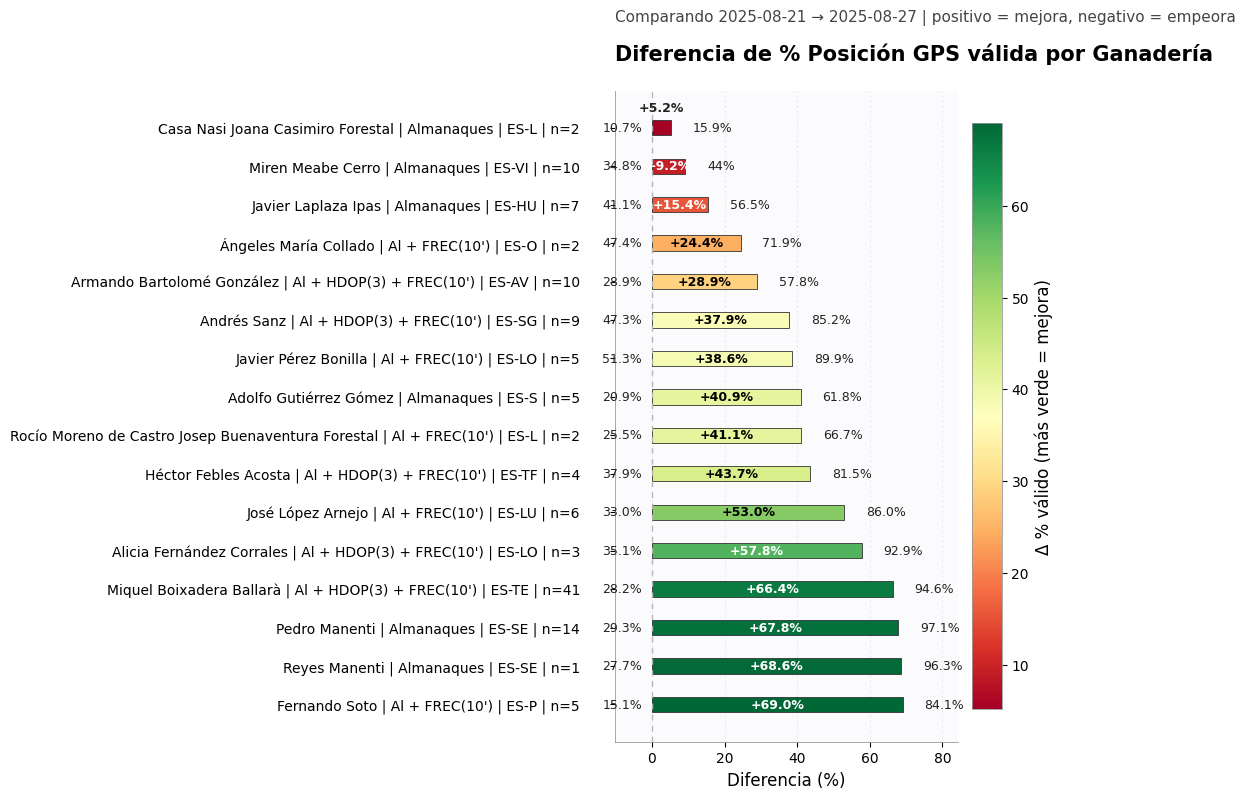

In [35]:
import re 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ======================
# 1) Preparación de datos
# ======================
df_plot = df_comparativa_validado.copy()

col_target_base = "Posición GPS válida (%)"
pct_cols = [c for c in df_plot.columns if c.startswith(col_target_base)]
if len(pct_cols) < 2:
    raise KeyError("No encuentro al menos dos columnas de '% válido' en df_comparativa_validado.")

def parse_bracket_date(col_name: str) -> pd.Timestamp:
    m = re.search(r"\[(\d{4}(?:-\d{2})?(?:-\d{2})?)\]\s*$", col_name)
    if not m:
        return pd.Timestamp.min
    raw = m.group(1)
    for fmt in ("%Y-%m-%d", "%Y-%m", "%Y"):
        try:
            return pd.to_datetime(raw, format=fmt)
        except Exception:
            pass
    return pd.Timestamp.min

pct_cols_sorted = sorted(pct_cols, key=parse_bracket_date)
fecha_1_col, fecha_2_col = pct_cols_sorted[0], pct_cols_sorted[-1]

# n_dispositivos del dataset más reciente (si existe)
devices_cols = [c for c in df_plot.columns if c.startswith("n_dispositivos")]
col_devices_recent = None
if devices_cols:
    m2 = re.search(r"\[(.+)\]\s*$", fecha_2_col)
    if m2:
        tag2 = m2.group(1)
        cand = [c for c in devices_cols if c.endswith(f"[{tag2}]")]
        col_devices_recent = cand[0] if cand else devices_cols[-1]
    else:
        col_devices_recent = devices_cols[-1]

col_ranch = "ranch_name"
col_cmd   = "Comandos Finales" if "Comandos Finales" in df_plot.columns else None
col_reg   = "Region" if "Region" in df_plot.columns else None

for c in [fecha_1_col, fecha_2_col]:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

if "Diferencia (%)" not in df_plot.columns:
    df_plot["Diferencia (%)"] = (df_plot[fecha_2_col] - df_plot[fecha_1_col]).round(2)

def make_y_label(row):
    parts = [str(row[col_ranch])]
    if col_cmd: parts.append(str(row[col_cmd]))
    if col_reg: parts.append(str(row[col_reg]))
    if col_devices_recent and pd.notna(row.get(col_devices_recent, np.nan)):
        try:
            parts.append(f"n={int(row[col_devices_recent])}")
        except Exception:
            pass
    return " | ".join(parts)

df_plot["label_y"] = df_plot.apply(make_y_label, axis=1)

TOP_N = 20   # número de ganaderías
df_top = df_plot.sort_values("Diferencia (%)", ascending=False).head(TOP_N).reset_index(drop=True)

# ======================
# 2) Estilo
# ======================
plt.rcParams.update({
    "axes.edgecolor": "#999999",
    "axes.linewidth": 0.6,
    "axes.titlesize": 15,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
})

cmap = mpl.cm.RdYlGn

# ---- diffs y normalización robusta
diff_vals_raw = df_top["Diferencia (%)"].astype(float).to_numpy()
mask = ~np.isnan(diff_vals_raw)
if not mask.any():
    raise ValueError("Todas las diferencias son NaN; no se puede graficar.")

diff_vals = diff_vals_raw.copy()
vmin = float(np.nanmin(diff_vals))
vmax = float(np.nanmax(diff_vals))

if vmin < 0 and vmax > 0:
    norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
else:
    if vmin == vmax:
        vmin, vmax = vmin - 1e-6, vmax + 1e-6
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# ======================
# 3) Figura
# ======================
n = len(df_top)
y_positions = np.arange(n) * 2.0
bar_height = 0.8

fig, ax = plt.subplots(figsize=(15, max(8, n * 0.55)))

ax.set_facecolor("#FBFBFD")
ax.axvline(0, linestyle=(0, (4, 4)), color="#B5B5B5", linewidth=1)

colors = cmap(norm(diff_vals))
bars = ax.barh(
    y_positions,
    diff_vals,
    height=bar_height,
    color=colors,
    edgecolor="#333333",
    linewidth=0.6
)

ax.xaxis.grid(True, linestyle=(0, (2, 4)), linewidth=0.6, color="#DADADA", alpha=0.85)
ax.set_axisbelow(True)

ax.set_yticks(y_positions)
ax.set_yticklabels(df_top["label_y"])

# separa los labels Y del eje
ax.tick_params(axis='y', which='major', pad=22)

def extract_tag(c):
    m = re.search(r"\[(.+)\]\s*$", c)
    return m.group(1) if m else c

tag1 = extract_tag(fecha_1_col)
tag2 = extract_tag(fecha_2_col)

ax.set_title("Diferencia de % Posición GPS válida por Ganadería",
             pad=22, loc="left", fontsize=15, fontweight="bold")

ax.text(
    0.0, 1.10,
    f"Comparando {tag1} → {tag2} | positivo = mejora, negativo = empeora",
    transform=ax.transAxes,
    ha="left", va="bottom",
    fontsize=11, color="#444"
)

ax.set_xlabel("Diferencia (%)")

fig.subplots_adjust(left=0.60, right=0.88, top=0.82, bottom=0.08)

def fmt_pct(x, decimals=1):
    if pd.isna(x):
        return ""
    x = float(x)
    return f"{int(x)}%" if x.is_integer() else f"{x:.{decimals}f}%"

def contrast_text_color(bg_rgba, threshold=0.55):
    r, g, b, _ = bg_rgba
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "white" if lum < threshold else "black"

xrng_real = (float(np.nanmax(diff_vals_raw)) - float(np.nanmin(diff_vals_raw)))
label_gap = max(6.0, 0.08 * (xrng_real if xrng_real > 0 else 100.0))

for i, row in df_top.iterrows():
    y = y_positions[i]
    diff = float(row["Diferencia (%)"])
    v1 = row[fecha_1_col]
    v2 = row[fecha_2_col]

    # Centro
    center_x = diff / 2.0
    bar_color = colors[i]
    center_color = contrast_text_color(bar_color, threshold=0.60) if abs(diff) > 6 else "#222"

    if abs(diff) <= 6:
        ax.text(center_x, y + (bar_height * 0.85), f"{diff:+.1f}%",
                ha="center", va="bottom", fontsize=9, fontweight="bold", color=center_color)
    else:
        ax.text(center_x, y, f"{diff:+.1f}%",
                ha="center", va="center", fontsize=9, fontweight="bold", color=center_color)

    # Izquierda
    if diff > 0:
        left_x = - max(2.5, 0.45 * label_gap)
    else:
        left_x = diff - 0.45 * label_gap
    ax.text(left_x, y, fmt_pct(v1), ha="right", va="center", fontsize=9, color="#222")

    # Derecha
    right_x = max(0.0, diff) + label_gap
    ax.text(right_x, y, fmt_pct(v2), ha="left", va="center", fontsize=9, color="#222")

# Límites X
base_pad = max(8.0, 0.08 * (xrng_real if xrng_real > 0 else 100.0))
ax.set_xlim(vmin - base_pad - label_gap * 1.2, vmax + base_pad + label_gap * 1.2)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    shrink=0.9,
    pad=0.035
)
cbar.set_label("Δ % válido (más verde = mejora)")

plt.show()


In [38]:
import pandas as pd

# --- 1) Filtro exacto (tolerante a espacios y mayúsculas/minúsculas)
df_almanaques = (
    df_comparativa_validado
      .assign(__cf=lambda d: d["Comandos Finales"].astype(str).str.strip().str.casefold())
      .loc[lambda d: d["__cf"].eq("almanaques")]
      .drop(columns="__cf")
      .copy()
)

print(f"Filas en df_almanaques: {len(df_almanaques):,}")


Filas en df_almanaques: 6


In [45]:
import pandas as pd

# --- fuentes (ya en tu sesión) ---
df_a = df_2025_08_21.copy()
df_b = df_2025_08_27.copy()
df_alm = df_almanaques.copy()

# --- renombres mínimos útiles ---
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    ren = {}
    if "RanchName" in df.columns and "ranch_name" not in df.columns: ren["RanchName"] = "ranch_name"
    if "Ganadería" in df.columns and "ranch_name" not in df.columns: ren["Ganadería"] = "ranch_name"
    if "ranch" in df.columns and "ranch_name" not in df.columns:     ren["ranch"] = "ranch_name"
    if "DeviceId" in df.columns and "device_id" not in df.columns:   ren["DeviceId"] = "device_id"
    if "serial_number" in df.columns and "SerialNumber" not in df.columns: ren["serial_number"] = "SerialNumber"
    if "model" in df.columns and "Model" not in df.columns:          ren["model"] = "Model"
    return df.rename(columns=ren) if ren else df

df_alm = normalize_cols(df_alm)
df_a   = normalize_cols(df_a)
df_b   = normalize_cols(df_b)

# --- lista de ganaderías objetivo (desde df_almanaques) ---
allowed_ranches = set(df_alm["ranch_name"].dropna().astype(str).str.strip())

# --- helper para extraer dispositivos por fecha ---
wanted = {"cow_pro", "ixo_track_pro", "ixotrack_pro"}

def pick_devices(df: pd.DataFrame) -> pd.DataFrame:
    if "ranch_name" not in df.columns:
        raise KeyError("Falta 'ranch_name' en el DF de fecha.")
    if "Model" not in df.columns:
        raise KeyError("Falta 'Model' en el DF de fecha.")
    # normaliza modelo
    model_norm = (
        df["Model"].astype(str)
          .str.lower().str.replace("-", "_").str.replace(" ", "_")
    )
    mask = model_norm.isin(wanted) & df["ranch_name"].astype(str).isin(allowed_ranches)

    cols_exist = [c for c in ["device_id", "SerialNumber"] if c in df.columns]
    if not cols_exist:
        raise KeyError("No encuentro 'device_id' ni 'SerialNumber' en el DF de fecha.")

    out = (
        df.loc[mask, ["ranch_name"] + cols_exist]
          .dropna(how="all", subset=cols_exist)
          .drop_duplicates()
          .reset_index(drop=True)
    )
    return out

# --- combinar fechas y deduplicar ---
parts = [pick_devices(df_a), pick_devices(df_b)]
dispositivos_almanaques = (
    pd.concat(parts, ignore_index=True)
      .drop_duplicates()
      .reset_index(drop=True)
)

print(f"✅ dispositivos_almanaques: {len(dispositivos_almanaques)} filas")
display(dispositivos_almanaques.head(20))


✅ dispositivos_almanaques: 39 filas


,ranch_name,device_id,SerialNumber
0,Miren Meabe Cerro,d9b1c141-0d45-4c73-b209-96ea5f9594e0,70015293.0
1,Adolfo Gutiérrez Gómez,56639ee1-e81d-4890-92fd-ce113df70d87,70015522.0
2,Adolfo Gutiérrez Gómez,c50616d3-6235-4e53-80a8-533e4e68631b,70012290.0
3,Adolfo Gutiérrez Gómez,7875f0bc-acda-40c6-a729-c5fba1bfbb25,70012289.0
4,Casa Nasi Joana Casimiro Forestal,4d980d3e-3193-4618-b9f8-3b6cc10fe6c0,70015082.0
5,Adolfo Gutiérrez Gómez,52bd9a64-c803-442b-b53c-a6e18e3e81a3,70012291.0
6,Adolfo Gutiérrez Gómez,9832a466-4a70-4a10-9838-2f37406f794f,70015816.0
7,Casa Nasi Joana Casimiro Forestal,694159d1-477a-45ff-9aa2-616019f45e51,70015084.0
8,Miren Meabe Cerro,b96e7b5e-6987-4d2e-a3a2-b29c6b42e514,70015295.0
9,Javier Laplaza Ipas,d14df370-e78b-4369-94d5-85af6313947d,70014287.0


In [49]:
import pandas as pd
import numpy as np
import re
import unicodedata

# === Entradas ===
df_a, tag_a = df_2025_08_21.copy(), "2025-08-21"
df_b, tag_b = df_2025_08_27.copy(), "2025-08-27"
df_alm = df_almanaques.copy()

# ---------- Helpers mínimos ----------
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    ren = {}
    if "DeviceId" in df.columns and "device_id" not in df.columns: ren["DeviceId"] = "device_id"
    if "serial_number" in df.columns and "SerialNumber" not in df.columns: ren["serial_number"] = "SerialNumber"
    if "RanchName" in df.columns and "ranch_name" not in df.columns: ren["RanchName"] = "ranch_name"
    if "Ganadería" in df.columns and "ranch_name" not in df.columns: ren["Ganadería"] = "ranch_name"
    if "ranch" in df.columns and "ranch_name" not in df.columns: ren["ranch"] = "ranch_name"
    if "model" in df.columns and "Model" not in df.columns: ren["model"] = "Model"
    return df.rename(columns=ren) if ren else df

def _norm(s: str) -> str:
    s = unicodedata.normalize("NFKD", str(s))
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    return re.sub(r"\s+", " ", s).strip().casefold()

def find_pct_col(df: pd.DataFrame) -> str | None:
    target = _norm("Posición GPS válida (%)")
    norm_map = {c: _norm(c) for c in df.columns}
    exact = [c for c,n in norm_map.items() if n == target]
    if exact: return exact[0]
    starts = [c for c,n in norm_map.items() if n.startswith(target)]
    if starts: return starts[0]
    for c,n in norm_map.items():
        if "posicion" in n and "valid" in n and ("%" in c or "pct" in n or "porcentaje" in n):
            return c
    return None

def pick_agg_first(x: pd.Series):
    return x.dropna().iloc[0] if x.notna().any() else np.nan

def per_date_by_device_enriched(df: pd.DataFrame, tag: str, allowed_ranches: set[str]) -> pd.DataFrame:
    """
    Filtra a ranches de df_almanaques y a modelos PRO (cow_pro, ixo_track_pro/ixotrack_pro),
    y devuelve por device_id: % válido [tag] + meta [tag] (Model, SerialNumber, ranch_name, Comandos Finales).
    """
    df = normalize_cols(df)
    # Requisitos
    for req in ["device_id", "Model", "ranch_name"]:
        if req not in df.columns:
            raise KeyError(f"Falta '{req}' en el DF {tag}.")
    # Filtrado por ranches (Almanaques)
    if allowed_ranches:
        df = df[df["ranch_name"].astype(str).isin(allowed_ranches)].copy()
    # Filtrado por modelos PRO
    model_norm = (
        df["Model"].astype(str)
          .str.lower().str.replace("-", "_").str.replace(" ", "_")
    )
    wanted = {"cow_pro", "ixo_track_pro", "ixotrack_pro"}
    df = df[model_norm.isin(wanted)].copy()
    if df.empty:
        return pd.DataFrame(columns=[
            "device_id",
            f"Posición GPS válida (%) [{tag}]",
            f"Model [{tag}]",
            f"SerialNumber [{tag}]",
            f"ranch_name [{tag}]",
            f"Comandos Finales [{tag}]",
        ])

    # % válido
    pct_col = find_pct_col(df)
    if pct_col is None:
        raise KeyError(f"No encuentro columna de % válido en DF {tag}.")

    # Agregado por device_id
    agg = {
        pct_col: "mean",
        "Model": pick_agg_first,
        "ranch_name": pick_agg_first,
    }
    if "SerialNumber" in df.columns:
        agg["SerialNumber"] = pick_agg_first
    if "Comandos Finales" in df.columns:
        agg["Comandos Finales"] = pick_agg_first

    g = df.groupby("device_id", as_index=False).agg(agg)

    # Renombrar con sufijos [tag]
    g = g.rename(columns={pct_col: f"Posición GPS válida (%) [{tag}]",
                          "Model": f"Model [{tag}]",
                          "ranch_name": f"ranch_name [{tag}]"})
    if "SerialNumber" in g.columns:
        g = g.rename(columns={"SerialNumber": f"SerialNumber [{tag}]"})
    if "Comandos Finales" in g.columns:
        g = g.rename(columns={"Comandos Finales": f"Comandos Finales [{tag}]"})

    return g

# ---------- Normalizar y preparar allowed_ranches ----------
df_a = normalize_cols(df_a)
df_b = normalize_cols(df_b)
df_alm = normalize_cols(df_alm)
allowed_ranches = set(df_alm["ranch_name"].dropna().astype(str).str.strip()) if "ranch_name" in df_alm.columns else set()

# ---------- Construir por fecha (filtrado PRO + Almanaques) ----------
a_dev = per_date_by_device_enriched(df_a, tag_a, allowed_ranches)
b_dev = per_date_by_device_enriched(df_b, tag_b, allowed_ranches)

# ---------- Merge por device_id ----------
out = pd.merge(a_dev, b_dev, on="device_id", how="outer")

# ---------- Coalesce de meta (prioriza la fecha más reciente) ----------
def coalesce(cols):
    cols = [c for c in cols if c in out.columns]
    if not cols: return pd.Series(pd.NA, index=out.index)
    if len(cols) == 1: return out[cols[0]]
    return out[cols[-1]].combine_first(out[cols[0]])

out["Model"]        = coalesce([f"Model [{tag_a}]",        f"Model [{tag_b}]"])
out["SerialNumber"] = coalesce([f"SerialNumber [{tag_a}]", f"SerialNumber [{tag_b}]"])
out["ranch_name"]   = coalesce([f"ranch_name [{tag_a}]",   f"ranch_name [{tag_b}]"])
out["Comandos Finales"] = coalesce([f"Comandos Finales [{tag_a}]", f"Comandos Finales [{tag_b}]"])

# ---------- Diferencia ----------
col_old = f"Posición GPS válida (%) [{tag_a}]"
col_new = f"Posición GPS válida (%) [{tag_b}]"
for c in [col_old, col_new]:
    if c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")
out["Diferencia (%)"] = (out.get(col_new) - out.get(col_old)).round(2)

# ---------- (opcional) Si existe dispositivos_almanaques con device_id, restringe a esa lista ----------
if "dispositivos_almanaques" in globals() and "device_id" in dispositivos_almanaques.columns:
    keep_devs = set(dispositivos_almanaques["device_id"].dropna())
    out = out[out["device_id"].isin(keep_devs)].copy()

# ---------- Orden final ----------
cols_order = [
    "device_id", "SerialNumber", "Model", "ranch_name", "Comandos Finales",
    col_old, col_new, "Diferencia (%)",
]
cols_present = [c for c in cols_order if c in out.columns]
out = out[cols_present].sort_values("Diferencia (%)", ascending=False, na_position="last").reset_index(drop=True)

print(f"✅ Resultado enriquecido (PRO + Almanaques): {out.shape[0]:,} filas x {out.shape[1]} cols")
display(out.head(20))


✅ Resultado enriquecido (PRO + Almanaques): 39 filas x 8 cols


<positron-console-cell-49>:119: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


,device_id,SerialNumber,Model,ranch_name,Comandos Finales,Posición GPS válida (%) [2025-08-21],Posición GPS válida (%) [2025-08-27],Diferencia (%)
0,74b61b6b-f697-44e0-80c7-db08c9584ac2,70014650,ixo_track_pro,Pedro Manenti,<NA>,25.36,100.00,74.64
1,c22393a4-8c40-43de-9ede-1560d71636cc,70014638,ixo_track_pro,Pedro Manenti,<NA>,24.09,96.43,72.34
2,b0e5a87b-d60d-45a0-890f-bbf6bf5aa7c4,70014644,ixo_track_pro,Pedro Manenti,<NA>,27.79,100.00,72.21
3,7d050db3-f147-46b2-bb7c-a30f90a2cb03,70014640,ixo_track_pro,Pedro Manenti,<NA>,28.93,100.00,71.07
4,67d168d6-f1c7-4a19-bd4a-2790d6b6277b,70014639,ixo_track_pro,Pedro Manenti,<NA>,29.10,100.00,70.90
5,2919f4ed-7e50-4a3d-ae58-d9df6f7c7a0e,70014651,ixo_track_pro,Pedro Manenti,<NA>,29.22,100.00,70.78
6,173e9139-eb75-4d80-a9ca-49e978ef8550,70014645,ixo_track_pro,Pedro Manenti,<NA>,29.99,100.00,70.01
7,b43b6eb5-b2de-4571-875c-d62d43d04fdb,70014642,ixo_track_pro,Pedro Manenti,<NA>,26.40,96.30,69.90
8,9816c482-5455-4566-ad01-924bfa87764f,70014643,ixo_track_pro,Pedro Manenti,<NA>,31.10,100.00,68.90
9,c1ae4413-7206-42d5-a9a4-d4dc75a75aca,70014662,ixo_track_pro,Reyes Manenti,<NA>,27.66,96.30,68.64


In [52]:
from pathlib import Path
import pandas as pd
import os
import openpyxl


def desktop_path():
    return Path(os.path.expandvars(r"%USERPROFILE%")) / "Desktop"

desktop = desktop_path()
ruta_xlsx = desktop / f"out{pd.Timestamp.now():%Y%m%d_%H%M%S}.xlsx"

# Sin especificar engine
with pd.ExcelWriter(ruta_xlsx) as writer:
    out.to_excel(writer, index=False, sheet_name="datos")

print(f"✅ Excel guardado en: {ruta_xlsx}")


✅ Excel guardado en: C:\Users\usuario\Desktop\out20250829_140256.xlsx


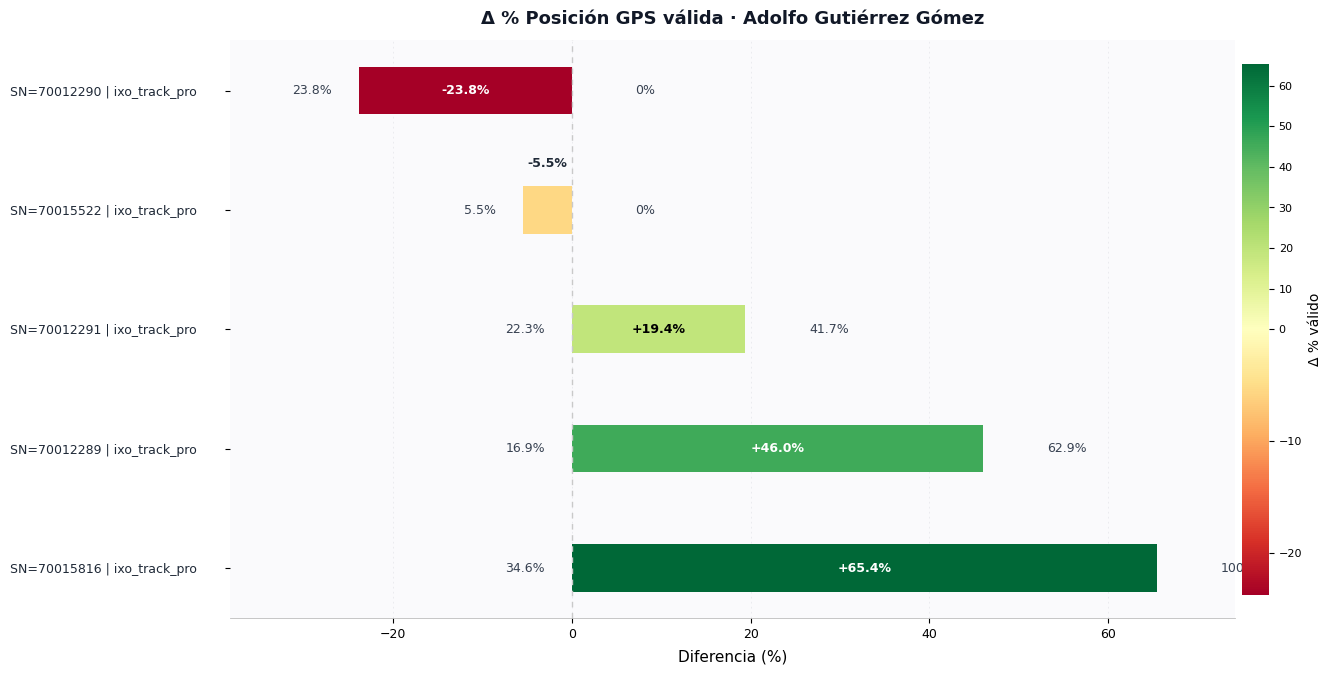

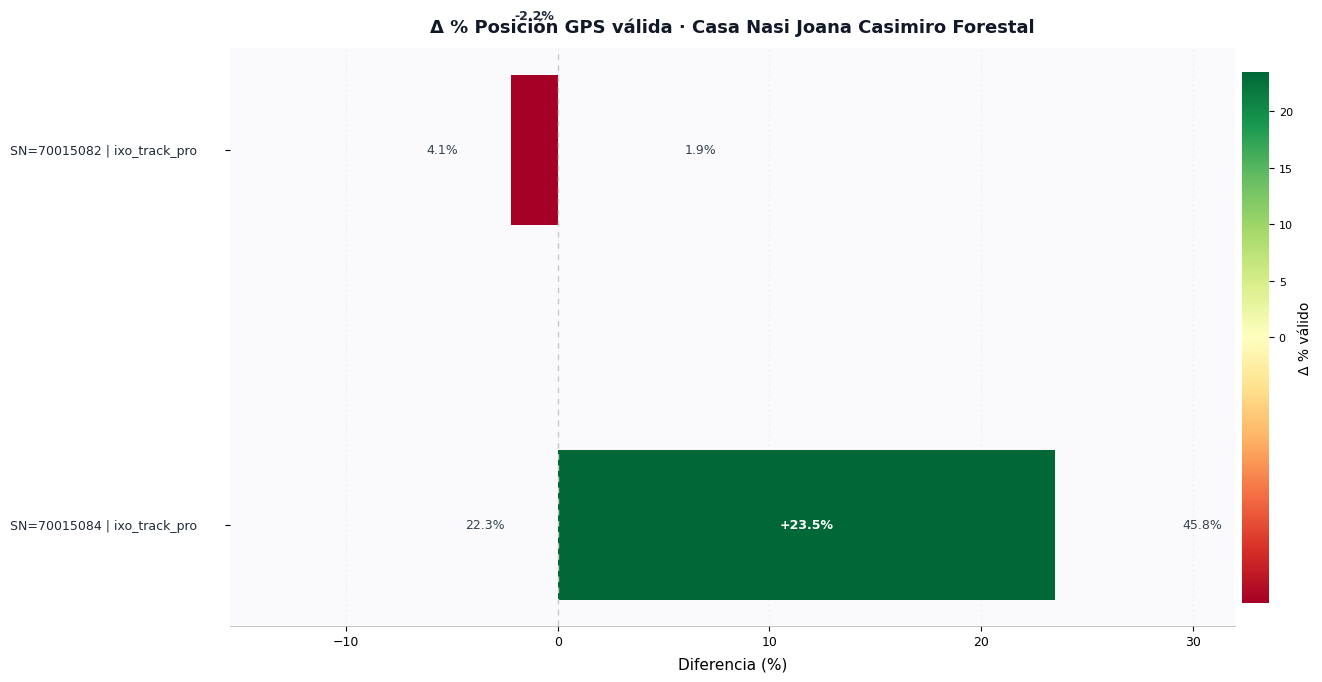

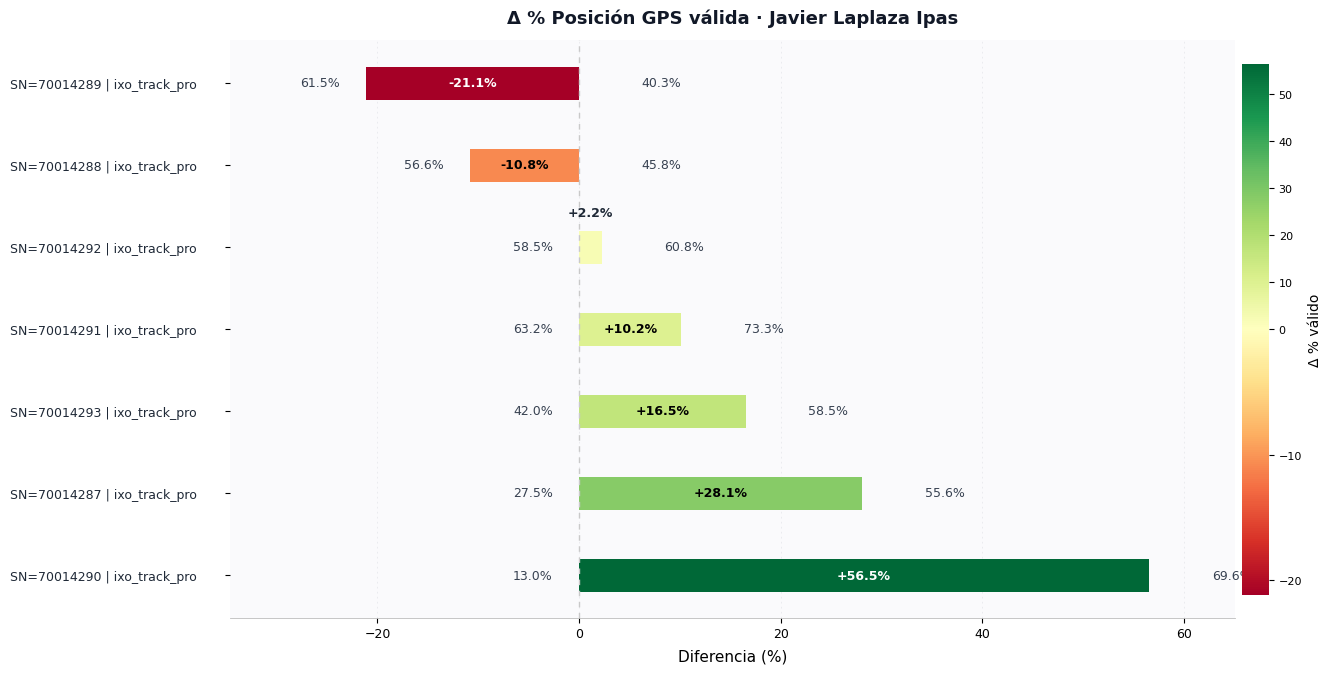

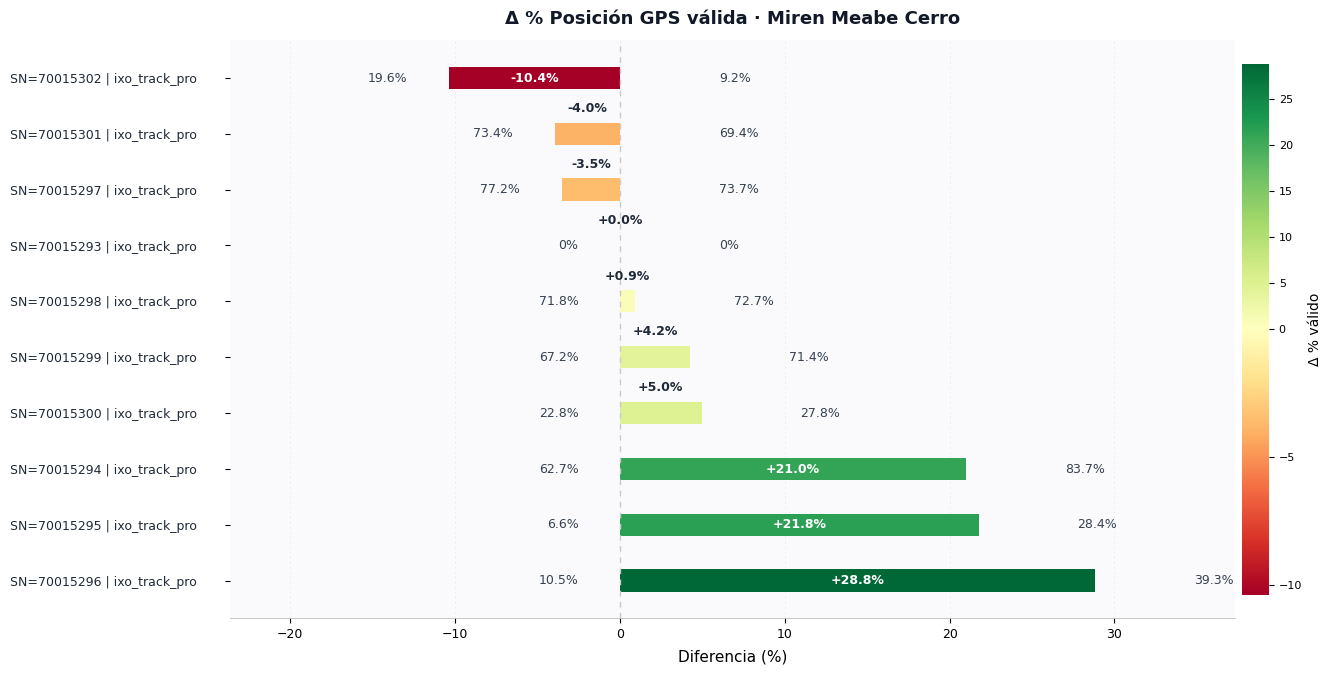

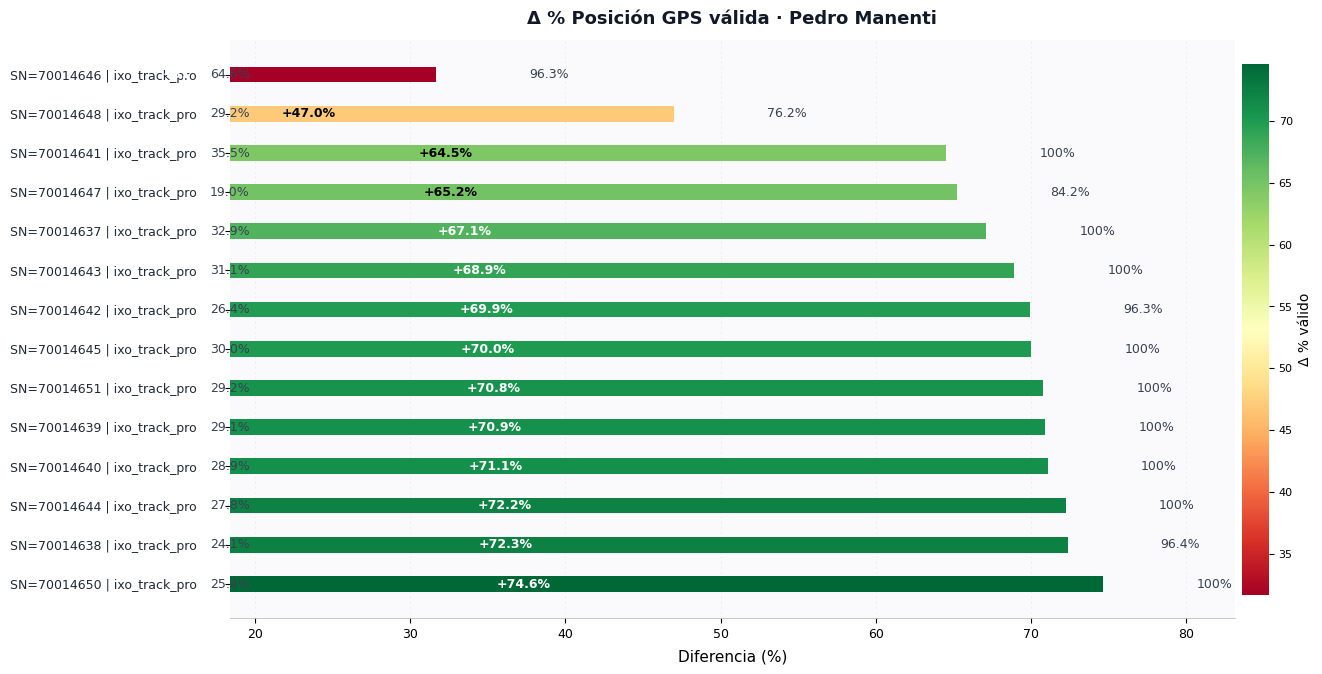

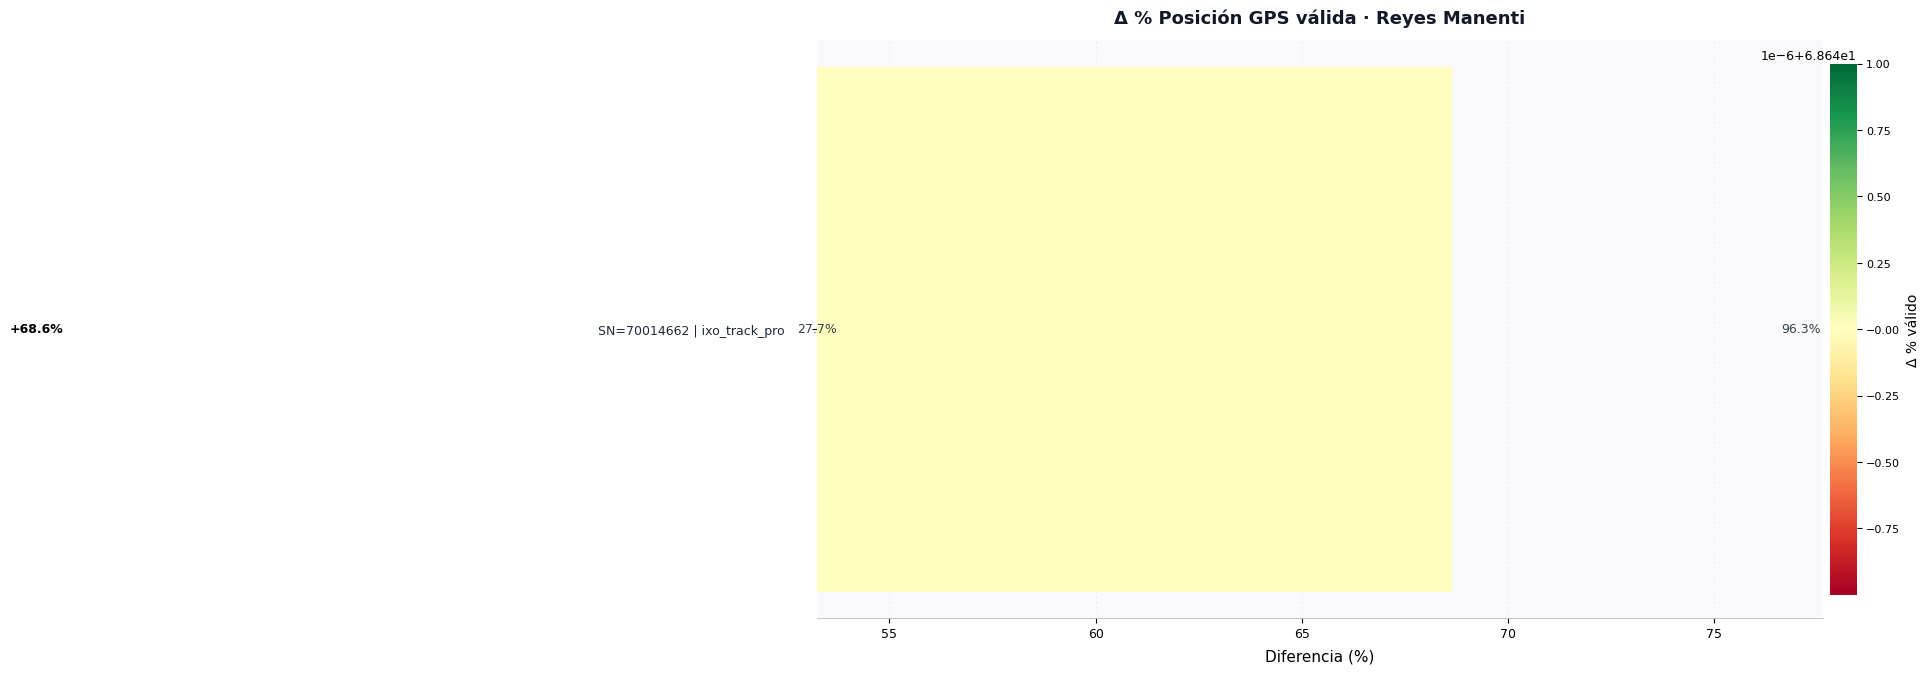

In [56]:
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ======================
# Parámetros de estilo/layout
# ======================
MAX_PER_FIG   = 40     # nº máx. de dispositivos por figura (None = todos en una sola)
RIGHT_PAD     = 0.97   # margen derecho pegado
CBAR_PAD      = 0.006  # separación colorbar
TITLE_FZ      = 13     # tamaño de título
YLABEL_PAD    = 20     # separación de las etiquetas Y respecto al eje
LEFT_EXTRA_PX = 28     # px extra de seguridad a la izquierda del yticklabel

# ======================
# 1) DataFrame a usar
# ======================
df_plot = out.copy()   # <<< usa tu DF 'out' enriquecido

# ======================
# 2) Detectar columnas de % válido (dos fechas)
# ======================
col_target_base = "Posición GPS válida (%)"
pct_cols = [c for c in df_plot.columns if str(c).startswith(col_target_base)]
if len(pct_cols) < 2:
    raise KeyError("No encuentro al menos dos columnas de '% válido' en 'out'.")

def parse_bracket_date(col_name: str) -> pd.Timestamp:
    m = re.search(r"\[(\d{4}(?:-\d{2})?(?:-\d{2})?)\]\s*$", str(col_name))
    if not m:
        return pd.Timestamp.min
    raw = m.group(1)
    for fmt in ("%Y-%m-%d", "%Y-%m", "%Y"):
        try:
            return pd.to_datetime(raw, format=fmt)
        except Exception:
            pass
    return pd.Timestamp.min

pct_cols_sorted = sorted(pct_cols, key=parse_bracket_date)
fecha_1_col, fecha_2_col = pct_cols_sorted[0], pct_cols_sorted[-1]

# ======================
# 3) Columnas meta (si existen)
# ======================
col_ranch = "ranch_name" if "ranch_name" in df_plot.columns else None
col_sn    = "SerialNumber" if "SerialNumber" in df_plot.columns else None
col_model = "Model" if "Model" in df_plot.columns else None
col_cmd   = "Comandos Finales" if "Comandos Finales" in df_plot.columns else None
col_reg   = "Region" if "Region" in df_plot.columns else None  # opcional

# Asegurar numéricos y diferencia
for c in [fecha_1_col, fecha_2_col]:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

if "Diferencia (%)" not in df_plot.columns:
    df_plot["Diferencia (%)"] = (df_plot[fecha_2_col] - df_plot[fecha_1_col]).round(2)

# ======================
# 4) Etiqueta por dispositivo (SIN device_id)
# ======================
def make_y_label(row):
    parts = []
    if col_sn   and pd.notna(row.get(col_sn)):     parts.append(f"SN={row[col_sn]}")
    if col_model and pd.notna(row.get(col_model)): parts.append(str(row[col_model]))
    if col_cmd  and pd.notna(row.get(col_cmd)):    parts.append(str(row[col_cmd]))
    if col_reg  and pd.notna(row.get(col_reg)):    parts.append(str(row[col_reg]))
    return " | ".join(parts) if parts else "(dispositivo)"

df_plot["label_y"] = df_plot.apply(make_y_label, axis=1)

# Si no hay ranch_name, hacemos una única "ganadería" genérica
if not col_ranch:
    df_plot["_fake_ranch_"] = "Todos"
    col_ranch = "_fake_ranch_"

# ======================
# 5) Estilo global
# ======================
plt.rcParams.update({
    "axes.edgecolor": "#BDBDBD",
    "axes.linewidth": 0.6,
    "axes.titlesize": TITLE_FZ,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
})
cmap = mpl.cm.RdYlGn

def fmt_pct(x, decimals=1):
    if pd.isna(x): return ""
    x = float(x)
    return f"{int(x)}%" if x.is_integer() else f"{x:.{decimals}f}%"

def contrast_text_color(bg_rgba, threshold=0.55):
    r, g, b, _ = bg_rgba
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "white" if lum < threshold else "black"

def extract_tag(c):
    m = re.search(r"\[(.+)\]\s*$", str(c))
    return m.group(1) if m else str(c)

tag1 = extract_tag(fecha_1_col)
tag2 = extract_tag(fecha_2_col)

def chunker(df, size):
    if size is None or len(df) <= size:
        yield 1, 1, df
    else:
        total = int(np.ceil(len(df) / size))
        for i in range(total):
            yield i + 1, total, df.iloc[i*size:(i+1)*size]

def auto_left_margin(fig, ax, extra_px=LEFT_EXTRA_PX, min_left=0.12, max_left=0.85):
    """Calcula el margen izquierdo necesario en función del ancho real de las ylabels."""
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bboxes = [t.get_window_extent(renderer=renderer) for t in ax.get_yticklabels()]
    max_w = max((b.width for b in bboxes), default=0.0) + float(extra_px)
    fig_w_px = fig.canvas.get_width_height()[0]
    left_needed = max_w / fig_w_px
    left = max(min_left, min(max_left, left_needed))
    # Mantener right fijo y aplicar
    fig.subplots_adjust(left=left, right=RIGHT_PAD)

# ======================
# 6) Plot por ganadería (todos los dispositivos)
# ======================
ganaderias = sorted(df_plot[col_ranch].dropna().astype(str).unique().tolist())

for ranch in ganaderias:
    df_g_all = df_plot[df_plot[col_ranch] == ranch].copy()
    df_g_all = df_g_all.sort_values("Diferencia (%)", ascending=False).reset_index(drop=True)

    if df_g_all["Diferencia (%)"].isna().all():
        print(f"(Todas las diferencias NaN para {ranch}; nada que graficar)")
        continue

    for part_idx, part_total, df_g in chunker(df_g_all, MAX_PER_FIG):
        diff_vals_raw = df_g["Diferencia (%)"].astype(float).to_numpy()
        if np.isnan(diff_vals_raw).all():
            continue

        vmin = float(np.nanmin(diff_vals_raw))
        vmax = float(np.nanmax(diff_vals_raw))
        if vmin < 0 and vmax > 0:
            norm = mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
        else:
            if vmin == vmax:
                vmin, vmax = vmin - 1e-6, vmax + 1e-6
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

        n = len(df_g)
        y_positions = np.arange(n) * 2.0
        bar_height = 0.8

        fig, ax = plt.subplots(figsize=(14.5, max(7.5, n * 0.52)))
        ax.set_facecolor("#FAFAFC")
        ax.axvline(0, linestyle=(0, (4, 4)), color="#C9C9C9", linewidth=1)

        colors = cmap(norm(diff_vals_raw))
        ax.barh(
            y_positions,
            diff_vals_raw,
            height=bar_height,
            color=colors,
            edgecolor="none"
        )

        ax.xaxis.grid(True, linestyle=(0, (2, 4)), linewidth=0.6, color="#E5E7EB", alpha=0.9)
        ax.set_axisbelow(True)

        ax.set_yticks(y_positions)
        ax.set_yticklabels(df_g["label_y"], color="#1F2937")
        ax.tick_params(axis='y', which='major', pad=YLABEL_PAD)

        # Título centrado, más pequeño
        title_suffix = f"  ·  parte {part_idx}/{part_total}" if part_total > 1 else ""
        ax.set_title(f"Δ % Posición GPS válida · {ranch}{title_suffix}",
                     pad=12, loc="center", fontsize=TITLE_FZ, fontweight="semibold", color="#111827")

        ax.set_xlabel("Diferencia (%)", labelpad=6)

        # --- Rango X ANTES de anotar para fijar un "guard" consistente
        xrng_real = float(np.nanmax(diff_vals_raw) - np.nanmin(diff_vals_raw))
        label_gap = max(6.0, 0.08 * (xrng_real if xrng_real > 0 else 100.0))
        base_pad = max(7.0, 0.06 * (xrng_real if xrng_real > 0 else 100.0))
        x_left  = vmin - base_pad - label_gap * 1.05
        x_right = vmax + base_pad + label_gap * 0.25
        ax.set_xlim(x_left, x_right)

        # --- Ajuste automático del margen izquierdo según ancho real de ylabels
        #     (garantiza que no se pisen con nada)
        auto_left_margin(fig, ax, extra_px=LEFT_EXTRA_PX)

        # Guard mínimo para textos dentro del eje (evita chocar con borde)
        guard = x_left + 0.02 * (x_right - x_left)

        # Anotaciones (% Δ centrado + % fecha1 izq + % fecha2 dcha)
        for i, row in df_g.iterrows():
            y = y_positions[i]
            diff = float(row["Diferencia (%)"])
            v1 = row[fecha_1_col]
            v2 = row[fecha_2_col]

            center_x = diff / 2.0
            bar_color = colors[i]
            center_color = contrast_text_color(bar_color, threshold=0.60) if abs(diff) > 6 else "#1F2937"

            if abs(diff) <= 6:
                ax.text(center_x, y + (bar_height * 0.85), f"{diff:+.1f}%",
                        ha="center", va="bottom", fontsize=9, fontweight="bold", color=center_color)
            else:
                ax.text(center_x, y, f"{diff:+.1f}%",
                        ha="center", va="center", fontsize=9, fontweight="bold", color=center_color)

            # % fecha 1 (izquierda) con guard y sin pisar
            left_candidate = (- max(2.2, 0.42 * label_gap)) if diff > 0 else (diff - 0.42 * label_gap)
            left_x = max(left_candidate, guard)  # respeta margen seguro
            ax.text(left_x, y, fmt_pct(v1), ha="right", va="center", fontsize=9, color="#374151", clip_on=False)

            # % fecha 2 (derecha)
            right_x = max(0.0, diff) + label_gap
            ax.text(right_x, y, fmt_pct(v2), ha="left", va="center", fontsize=9, color="#374151")

        for spine in ["top", "right", "left"]:
            ax.spines[spine].set_visible(False)

        # Colorbar estilizada y pegada
        cbar = fig.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax=ax,
            orientation="vertical",
            shrink=0.92,
            pad=CBAR_PAD
        )
        cbar.set_label("Δ % válido", fontsize=10)
        cbar.outline.set_visible(False)
        cbar.ax.tick_params(labelsize=8)

        plt.show()
